# Linear Modeling of House Price

## 1. Introduction

## 2. Preparing the Dataset

In [19]:
import pandas as pd
import numpy as np
from Modules.dataexploration import DataExploration

pd.set_option('display.float', '{:,.2f}'.format)
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 75)
pd.set_option('display.max_info_columns', 50)

In [20]:
house_df = pd.read_csv('Dataset\jabodetabek_house_data_prcsd.csv')

### 2.1. Subsetting the Test Set for Assessing Prediction

In [21]:
from sklearn.model_selection import train_test_split

X = house_df.drop('price_in_rp', axis=1)
y = house_df.price_in_rp

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=99
)

### 2.2. Missing Values

First let's review missing data from our original dataset (yes, not `train` or `test set`). By evaluating `original dataset`, we analyze the possibility of missing value for both scenarios.

In [22]:
numerical_features = house_df.select_dtypes(exclude=['object', 'category']).columns
DataExploration(house_df).show_nans_or_zeroes('nans', numerical_features)

,Nans Count,Nans Percentage (%),Data Types
price_in_rp,0,0.00,float64
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,33,0.93,float64
bathrooms,29,0.82,float64
land_size_m2,2,0.06,float64
building_size_m2,2,0.06,float64
carports,0,0.00,int64
maid_bedrooms,0,0.00,int64
maid_bathrooms,0,0.00,int64


In [23]:
non_numeric_features = house_df.select_dtypes(include=['object']).columns
DataExploration(house_df).show_nans_or_zeroes('nans', non_numeric_features)

,Nans Count,Nans Percentage (%),Data Types
url,0,0.00,object
title,0,0.00,object
address,0,0.00,object
district,0,0.00,object
city,0,0.00,object
facilities,0,0.00,object
property_type,1,0.03,object
ads_id,4,0.11,object
certificate,141,3.99,object
electricity,0,0.00,object


Remember that those observations (from our original dataset) with missing records may exist in `training set`, `test set` or may be in both. Therefore, we must develop method to handle missing value that works for `training set`, `test set`, and even `potential future data` which we want to predict if any. Possible method:

1. Drop observations that have missing `bathrooms` or `bedrooms`, `land_size` and `building_size` records
2. Drop `building_age`, `year_built`, and `building_orientation` which have a lot of missing value
3. For missing `floors` and `electricity_num`, will be imputed. Features that used for imputation is best choosen according to its correlation coefficient (previous chapter).
4. For missing `certificate`, let's assume `certificate = lainnya`.
5. For missing `property_condition` and `furnishing`, let's assume majority of data.

According to above explanation, it should be noted that if there are any `future data` that we want to predict, the only missing features that can be considered are `floors`, `electricity`, `certificate`, `property_condition` and `furnishing`. Other than that, the prediction can't be performed.

In below codes, note that the imputation is fitted only with `train set` to ensure that the prediction model is isolated from `test set` (avoding data leakage)

In [24]:
from sklearn.impute import SimpleImputer, KNNImputer

# 1. Drop observations that missing vital records
X_train = X_train\
    .dropna(subset=['bedrooms', 'bathrooms', 'building_size_m2', 'land_size_m2'])
y_train = y_train[X_train.index] # remember to also drop the particular index of label data
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
# 2. Drop features with lot of NaN    
X_train = X_train\
    .drop(['building_age', 'year_built', 'building_orientation'], axis=1)
# 3.a. Impute missing `floors`
knn_imputer = KNNImputer(n_neighbors=1)
missing_floors_index = X_train[X_train.floors.isna()].index
features_estimator_floors = ['building_size_m2', 'bedrooms', 'bathrooms', 'floors']
imputer_floors = knn_imputer.fit(X_train[features_estimator_floors])
imputed_data_floors = imputer_floors.transform(X_train[features_estimator_floors])
X_train = X_train.assign(
    floors = imputed_data_floors[:, 3]
)
# 3.b. Impute missing `Electricity`
features_estimator_electricity = [
    'building_size_m2', 'bedrooms', 'bathrooms', 'floors', 'electricity_num'
]
missing_electricity_index = X_train[X_train.electricity_num.isna()].index
imputer_electricity = knn_imputer.fit(X_train[features_estimator_electricity])
imputed_data_electricity = imputer_electricity.transform(X_train[features_estimator_electricity])
X_train = X_train.assign(
    electricity_num = imputed_data_electricity[:, 4]
)
# 4. Impute missing `certificate`
constant_imputer = SimpleImputer(strategy='constant', fill_value='lainnya (ppjb,girik,adat,dll)')
X_train['certificate'] = constant_imputer.fit_transform(X_train[['certificate']]).flatten()
# 5. Impute missing `property_condition` and `furnishing`
frequent_imputer = SimpleImputer(strategy='most_frequent')
X_train['property_condition'] = frequent_imputer\
    .fit_transform(X_train[['property_condition']])\
    .flatten()
X_train['furnishing'] = frequent_imputer\
    .fit_transform(X_train[['furnishing']])\
    .flatten()

Let's see the imputation result:

In [25]:
# missing floor imputation results
show_features = ['building_size_m2', 'land_size_m2', 'bedrooms', 'bathrooms', 'floors']
pd.merge(
    X_train.iloc[missing_floors_index, X_train.columns.get_indexer(show_features)],
    y_train, left_index=True, right_index=True
)

,building_size_m2,land_size_m2,bedrooms,bathrooms,floors,price_in_rp
474,358.00,200.00,4.00,4.00,3.00,"10,100,000,000.00"
2262,200.00,187.00,3.00,3.00,2.00,"2,750,000,000.00"
2766,250.00,320.00,4.00,4.00,2.00,"8,300,000,000.00"


In [26]:
# missing electricity imputation results
show_features = ['building_size_m2', 'land_size_m2', 'bedrooms', 'bathrooms', 'floors', 'electricity_num']
pd.merge(
    X_train\
    .iloc[missing_electricity_index, X_train.columns.get_indexer(show_features)]\
    .head(),
    y_train, left_index=True, right_index=True
)

,building_size_m2,land_size_m2,bedrooms,bathrooms,floors,electricity_num,price_in_rp
5,249.00,180.00,4.00,3.00,2.00,"7,700.00","3,550,000,000.00"
7,125.00,237.00,3.00,2.00,2.00,"2,200.00","2,350,000,000.00"
9,285.00,220.00,4.00,4.00,2.00,"3,500.00","7,400,000,000.00"
11,839.00,785.00,6.00,5.00,3.00,"11,000.00","26,000,000,000.00"
14,212.00,170.00,4.00,3.00,2.00,"5,500.00","5,280,000,000.00"


### 2.3. Unnecessary Features and Features with High Cardinality

In [27]:
cols_to_drop = ['url', 'title', 'address', 'district', 'ads_id', 'facilities', 'property_type', 'electricity']
X_train.drop(cols_to_drop, axis=1, inplace=True)

### 2.4. Conclusion: Prepared Features

In [28]:
numerical_features = X_train.select_dtypes(exclude=['object', 'category']).columns
DataExploration(X_train).show_nans_or_zeroes('nans', numerical_features)

,Nans Count,Nans Percentage (%),Data Types
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,float64
bathrooms,0,0.00,float64
land_size_m2,0,0.00,float64
building_size_m2,0,0.00,float64
carports,0,0.00,int64
maid_bedrooms,0,0.00,int64
maid_bathrooms,0,0.00,int64
floors,0,0.00,float64


In [29]:
non_numeric_features = X_train.select_dtypes(include=['object']).columns
DataExploration(X_train).show_nans_or_zeroes('nans', non_numeric_features)

,Nans Count,Nans Percentage (%),Data Types
city,0,0.00,object
certificate,0,0.00,object
property_condition,0,0.00,object
furnishing,0,0.00,object


### 2.5. Additional: Pipeline for Test Set

#### **Transformer to drop Observations with Missing Records**

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

class RowsDropper(BaseEstimator, TransformerMixin):
    """ 
    Remove observations that missing any records from features that
    specified in `mandatory_features` 
    """
    def __init__(self, mandatory_features):
        self.mandatory_features = mandatory_features.copy()
        self.dropped_index = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        self.dropped_index = X[X[self.mandatory_features].isna()].index
        X_new = X.dropna(subset=self.mandatory_features)
        X_new.reset_index(drop=True, inplace=True)
        return X_new
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, **fit_params).transform(X)

#### **Features-Dropper Transformer**

In [31]:
class FeaturesDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_list):
        self.drop_list = drop_list.copy()
        self.cols_dropped = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # checking if streamed data has unused features
        self.cols_dropped +=\
            [column for column in X.columns if column in self.drop_list]
        if self.cols_dropped:
            X_new = X.drop(self.cols_dropped, axis=1)
            return X_new
        else:
            return X
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, **fit_params).transform(X)

#### **Transformer for Specific Columns**

In [32]:
class FloorsKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._knn_imputer = KNNImputer(n_neighbors=1)
        self._features_estimator_floors = ['building_size_m2', 'bedrooms', 'bathrooms', 'floors']

    def fit(self, X, y=None):
        X_fit = X.copy()
        self._knn_imputer = self._knn_imputer.fit(X_fit[self._features_estimator_floors])
        return self

    def transform(self, X, y=None):
        X_transf = X.copy()
        imputed_data_floors = self._knn_imputer.transform(X_transf[self._features_estimator_floors])
        X_new = X_transf.assign(
            floors = imputed_data_floors[:, 3]
        )
        return X_new
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, **fit_params).transform(X)

class ElectricityKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._knn_imputer = KNNImputer(n_neighbors=1)
        self._features_estimator_electricity = \
            ['building_size_m2', 'bedrooms', 'bathrooms', 'floors', 'electricity_num']

    def fit(self, X, y=None):
        X_fit = X.copy()
        self._knn_imputer = self._knn_imputer.fit(X_fit[self._features_estimator_electricity])
        return self

    def transform(self, X, y=None):
        X_transf = X.copy()
        imputed_data_electricity = self._knn_imputer.transform(X_transf[self._features_estimator_electricity])
        X_new = X_transf.assign(
            electricity_num = imputed_data_electricity[:, 4]
        )
        return X_new
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, **fit_params).transform(X)

#### **Creating Pipeline for Train-Test Set**

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config

mandatory_features = ['price_in_rp', 'bedrooms', 'bathrooms', 'building_size_m2', 'land_size_m2']
columns_to_drop = [
            'building_age', 'year_built', 'building_orientation',
            'url', 'title', 'address', 'district', 'ads_id', 'facilities', 
            'property_type', 'electricity'
            ]
rows_dropper = RowsDropper(mandatory_features)
features_dropper = FeaturesDropper(columns_to_drop)
floors_imputer = FloorsKNNImputer()
electricity_imputer = ElectricityKNNImputer()
certificate_imputer = SimpleImputer(strategy='constant', fill_value='lainnya (ppjb,girik,adat,dll)')
features_transf = ColumnTransformer([
    ('certificate_impute', certificate_imputer, ['certificate']),
    ('property_condition_impute', SimpleImputer(strategy='most_frequent'), ['property_condition']),
    ('furnishing_impute', SimpleImputer(strategy='most_frequent'), ['furnishing'])
    ], remainder='passthrough')
dataset_transform_pipeline = make_pipeline(
    rows_dropper,
    features_dropper,
    floors_imputer,
    electricity_imputer,
    features_transf
    )

set_config(display='diagram')
dataset_transform_pipeline

Pipeline(steps=[('rowsdropper',
                 RowsDropper(mandatory_features=['price_in_rp', 'bedrooms',
                                                 'bathrooms',
                                                 'building_size_m2',
                                                 'land_size_m2'])),
                ('featuresdropper',
                 FeaturesDropper(drop_list=['building_age', 'year_built',
                                            'building_orientation', 'url',
                                            'title', 'address', 'district',
                                            'ads_id', 'facilities',
                                            'property_type', 'electricity'])),
                ('floorsknnimputer', Floors...
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('certificate_impute',
                                                  SimpleImputer(fill_value='lainnya '
                                                                           '(ppjb,girik,adat,dll)',
                                                                strategy='constant'),
                                                  ['certificate']),
                                                 ('property_condition_impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['property_condition']),
                                                 ('furnishing_impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['furnishing'])]))])

#### **Demonstrating Pipeline for Train Set**

In [34]:
df_train, df_test =  train_test_split(house_df, test_size=0.1, random_state=99)

In [35]:
transfd_columns = ['certificate', 'property_condition', 'furnishing']
dataset_columns = \
    transfd_columns + [column for column in house_df.drop(columns_to_drop, axis=1) if column not in transfd_columns]

train_set_transfd = pd.DataFrame(
    dataset_transform_pipeline.fit_transform(df_train), 
    columns=dataset_columns)
for column in train_set_transfd:
    train_set_transfd[column] = pd.to_numeric(train_set_transfd[column], errors='ignore')
    
DataExploration(train_set_transfd).show_nans_or_zeroes('nans')

,Nans Count,Nans Percentage (%),Data Types
certificate,0,0.00,object
property_condition,0,0.00,object
furnishing,0,0.00,object
price_in_rp,0,0.00,float64
city,0,0.00,object
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,float64
bathrooms,0,0.00,float64
land_size_m2,0,0.00,float64


In [36]:
# missing floor imputation results
show_features = ['building_size_m2', 'land_size_m2', 'bedrooms', 'bathrooms', 'floors', 'price_in_rp']
train_set_transfd .iloc[missing_floors_index, train_set_transfd .columns.get_indexer(show_features)]

,building_size_m2,land_size_m2,bedrooms,bathrooms,floors,price_in_rp
474,358.00,200.00,4.00,4.00,3.00,"10,100,000,000.00"
2262,200.00,187.00,3.00,3.00,2.00,"2,750,000,000.00"
2766,250.00,320.00,4.00,4.00,2.00,"8,300,000,000.00"


In [37]:
# missing electricity imputation results
show_features = ['building_size_m2', 'land_size_m2', 'bedrooms', 'bathrooms', 'floors', 'electricity_num', 'price_in_rp']
train_set_transfd \
    .iloc[missing_electricity_index, train_set_transfd.columns.get_indexer(show_features)]\
    .head()

,building_size_m2,land_size_m2,bedrooms,bathrooms,floors,electricity_num,price_in_rp
5,249.00,180.00,4.00,3.00,2.00,"7,700.00","3,550,000,000.00"
7,125.00,237.00,3.00,2.00,2.00,"2,200.00","2,350,000,000.00"
9,285.00,220.00,4.00,4.00,2.00,"3,500.00","7,400,000,000.00"
11,839.00,785.00,6.00,5.00,3.00,"11,000.00","26,000,000,000.00"
14,212.00,170.00,4.00,3.00,2.00,"5,500.00","5,280,000,000.00"


#### **Demonstrating Pipeline for Test Set**

In [38]:
test_set_transfd = pd.DataFrame(dataset_transform_pipeline.transform(df_test), columns=dataset_columns)
for column in test_set_transfd:
    test_set_transfd[column] = pd.to_numeric(test_set_transfd[column], errors='ignore')
DataExploration(test_set_transfd).show_nans_or_zeroes('nans')

,Nans Count,Nans Percentage (%),Data Types
certificate,0,0.00,object
property_condition,0,0.00,object
furnishing,0,0.00,object
price_in_rp,0,0.00,float64
city,0,0.00,object
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,float64
bathrooms,0,0.00,float64
land_size_m2,0,0.00,float64


#### **Exporting Train-Test Set for other Models**

In [39]:
from joblib import dump

dump(dataset_transform_pipeline, 'Output\dataset_transform_pipeline.joblib')

['Output\\dataset_transform_pipeline.joblib']

In [40]:
# Train set
X_train = train_set_transfd.drop('price_in_rp', axis=1)
y_train = train_set_transfd[['price_in_rp']]
# Test set
X_test = test_set_transfd.drop('price_in_rp', axis=1)
y_test = test_set_transfd[['price_in_rp']]
# Export to csv
X_train.to_csv('Dataset/X_train.csv')
y_train.to_csv('Dataset/y_train.csv')
X_test.to_csv('Dataset/X_test.csv')
y_test.to_csv('Dataset/y_test.csv')


## 3. Linear Modeling: Ordinary Least Square

In [41]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.api import OLS
from statsmodels.tools import add_constant

X = train_set_transfd
X = add_constant(X)
# regression formula
f = 'price_in_rp ~ building_size_m2'
lm = smf.ols(formula=f, data=X)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_in_rp   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     2605.
Date:                Mon, 24 Oct 2022   Prob (F-statistic):               0.00
Time:                        16:13:17   Log-Likelihood:                -75861.
No. Observations:                3146   AIC:                         1.517e+05
Df Residuals:                    3144   BIC:                         1.517e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -8.835e+08    1.6e+08     -5.515      0.000    -1.2e+09   -5.69e+08
building_size_m2   2.61e+07   5.11e+05     51.039      0.000    2.51e+07    2.71e+07
==============================================================================
Omnibus:                     5605.874   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11538237.038
Skew:                          12.354   Prob(JB):                         0.00
Kurtosis:                     298.655   Cond. No.                         392.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

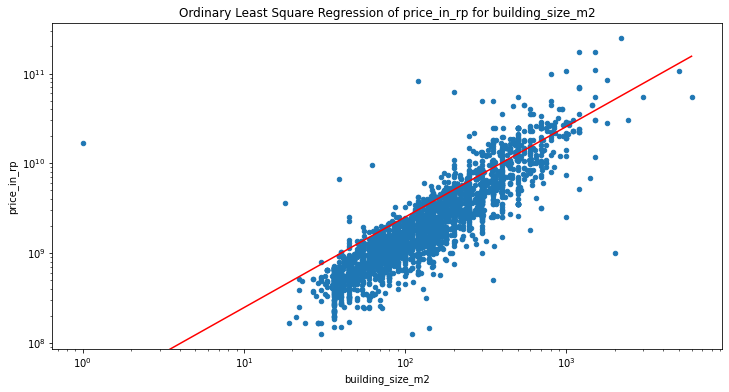

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# linear OLS
x_linear = pd.DataFrame(
    {'building_size_m2': [0, X['building_size_m2'].max()]}
)
x_linear = add_constant(x_linear)
y_linear = results.predict(x_linear)

# plot
fig, ax = plt.subplots(figsize=(12, 6))
X.plot(kind='scatter', x='building_size_m2', y='price_in_rp', ax=ax)
sns.lineplot(x=x_linear['building_size_m2'], y=y_linear, color='r', ax=ax)
ax.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')
ax.set_xscale('log')
ax.set_yscale('log')